# IForest

In [71]:
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix, precision_score
import numpy as np
import joblib

def run_cmdline_original():
    data = []
    labels = []
    with open("/root/commandDetect/kg/command_data.test2", "r") as file:
        for line in file:
            parts = line.strip().split('\"')
            if len(parts) >= 4:
                #uid, timestamp, pcomm, ppcomm, ppid, operation = parts[1], parts[3], parts[5], parts[9], parts[11], parts[15]
                #uid, timestamp, pcomm, ppcomm, ppid, cmdline, category = parts[1], parts[3], parts[5], parts[9], parts[11], parts[15], parts[17]
                uid, timestamp, pcomm, ppcomm, ppid, cmdline = parts[1], parts[3], parts[5], parts[9], parts[11], parts[15]
                data.append([uid, timestamp, cmdline])
            labels.append(int(line.strip()[-1]))  
            
    data_tmp = data
    data = np.array(data)
    
    # 提取时间并编码
    timestamps = [np.datetime64(item[0]) for item in data]
    le_timestamp = LabelEncoder()
    data[:, 1] = le_timestamp.fit_transform(timestamps)
    
    # 将进程名编码为整数
    le_process = LabelEncoder()
    data[:, 0] = le_process.fit_transform(data[:, 1])
    data[:, 2] = le_process.fit_transform(data[:, 2])
    
    clf = IsolationForest(contamination=0.01, random_state=42)
    clf.fit(data)
    
    # joblib.dump(clf, 'if_model.pkl')
    
    predictions = clf.predict(data)

    for i, pred in enumerate(predictions):
        if pred == -1:
            print(f"进程链 {i+1} 可能是入侵")
            print(data_tmp[i])
        else:
            print(f"进程链 {i+1} 正常")
            

    predictions = [1 if pred == -1 else 0 for pred in predictions]

    # 计算指标
    precision = accuracy_score(labels, predictions)
    accuracy = accuracy_score(labels, predictions)
    recall = recall_score(labels, predictions, average='macro')
    f1 = f1_score(labels, predictions, average='macro')
    
    print("Accuracy:", accuracy)
    print("Precision", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)


def run_original():
    data = []
    labels = []
    with open("/root/commandDetect/kg/command_data.test2", "r") as file:
        for line in file:
            parts = line.strip().split('\"')
            if len(parts) >= 4:
                #uid, timestamp, pcomm, ppcomm, ppid, operation = parts[1], parts[3], parts[5], parts[9], parts[11], parts[15]
                #uid, timestamp, pcomm, ppcomm, ppid, cmdline, category = parts[1], parts[3], parts[5], parts[9], parts[11], parts[15], parts[17]
                uid, timestamp, pcomm, ppcomm, ppid, cmdline = parts[1], parts[3], parts[5], parts[9], parts[11], parts[15]
                data.append([uid, timestamp, ppcomm, pcomm, cmdline])
            labels.append(int(line.strip()[-1]))  
    data_tmp = data
    data = np.array(data)
    
    # 提取时间并编码
    timestamps = [np.datetime64(item[0]) for item in data]
    le_timestamp = LabelEncoder()
    data[:, 1] = le_timestamp.fit_transform(timestamps)
    
    # 将进程名编码为整数
    le_process = LabelEncoder()
    data[:, 0] = le_process.fit_transform(data[:, 1])
    data[:, 2] = le_process.fit_transform(data[:, 2])
    data[:, 3] = le_process.fit_transform(data[:, 3])
    data[:, 4] = le_process.fit_transform(data[:, 4])
    
    clf = IsolationForest(contamination=0.01, random_state=42)
    clf.fit(data)
    
    # joblib.dump(clf, 'if_model.pkl')
    
    predictions = clf.predict(data)

    for i, pred in enumerate(predictions):
        if pred == -1:
            print(f"进程链 {i+1} 可能是入侵")
            print(data_tmp[i])
        else:
            print(f"进程链 {i+1} 正常")
            

    predictions = [1 if pred == -1 else 0 for pred in predictions]

    # 计算指标
    precision = accuracy_score(labels, predictions)
    accuracy = accuracy_score(labels, predictions)
    recall = recall_score(labels, predictions, average='macro')
    f1 = f1_score(labels, predictions, average='macro')
    
    print("Accuracy:", accuracy)
    print("Precision", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)


def upload_data():
    from py2neo import Graph, Node, Relationship
    from datetime import datetime
    import requests


    graph = Graph("bolt://localhost:7687", user="neo4j", password="123456")

    query1 = """
        match (n) detach delete (n)
    """
    result1 = graph.run(query1).data()

    query2 = """
        call gds.graph.drop("myGraph")
    """
    result2 = graph.run(query2).data()

    with open("/root/commandDetect/kg/command_data.test2", "r") as file:
        for line in file:
            try:
    
                data = line.strip().split('"')
                #print(data)
                uid, time, child_comm, child_pid, parent_comm, parent_pid, return_code, cmdline, option = data[1], data[3], data[5], data[7], data[9], data[11], data[13], data[15], data[17]
                #print(timestamp, child_comm, child_pid, parent_comm, parent_pid, return_code, cmdline)
                date_object = datetime.strptime(time, '%Y-%m-%d %H:%M:%S')
                timestamp = date_object.timestamp()
                label = int(line.strip()[-1])
                id = str(time) + '-' + str(child_pid)
                # 创建父进程和子进程节点
                parent_process = Node("Process", id=id, pid=parent_pid, name=parent_comm, comm=parent_comm)
                child_process = Node("Process", id=id,pid=child_pid, name=child_comm, comm=child_comm)
    
                # 使用 Relationship() 创建关系
                rel = Relationship(parent_process, "create_process", child_process)
                rel["uid"] = uid
                rel["time"] = timestamp
                rel["cmdline"] = cmdline
                rel["return"] = return_code
                rel["option"] = option
                rel["label"] = label
                #rel["evil_weight"] = get_class_probability(cmdline)
                #rel["anomaly_score"] = get_anomaly_score(timestamp,parent_comm,child_comm)
    
                # 使用 graph.merge 来合并节点和关系，确保它们在数据库中是唯一的
                graph.merge(parent_process, "Process", "pid")
                graph.merge(child_process, "Process", "pid")
                graph.merge(rel)
            except Exception as e:
                pass
                
    query3 = """
        CALL gds.graph.project(
        'myGraph',
        'Process',
        {
            create_process: {
                orientation: 'UNDIRECTED'
            }
        },
        {
            relationshipProperties: 'time'
        })
    """
    result3 = graph.run(query3).data()

    print("Data imported into Neo4j database.")
    
def run_graph():
    from py2neo import Graph
    graph = Graph("bolt://localhost:7687", user="neo4j", password="123456")
    query1 = """
        CALL gds.louvain.stream('myGraph')
        YIELD nodeId, communityId, intermediateCommunityIds
        RETURN DISTINCT communityId
        ORDER BY communityId ASC
    """  
    result1 = graph.run(query1).data()
    
    community_ids = [record['communityId'] for record in result1]

    community_results = []

    all_labels = []
    all_predictions = []
    
    for community_id in community_ids:
        query2 = f"""
            CALL gds.louvain.stream('myGraph')
            YIELD nodeId, communityId, intermediateCommunityIds
            WHERE communityId = {community_id}
            MATCH (n)-[r]->(m)
            WHERE id(n) = nodeId
            RETURN n, r, m
            ORDER BY communityId ASC 
        """
        result2 = graph.run(query2).data()
        community_results.append(result2)

    for i, community_id in enumerate(community_ids):
        data = []
        labels = []
        print("****"*10)
        print(f"Community {community_id}:")
        
        for record in community_results[i]:        
            ppnode = record['n']
            relationship = record['r']
            pnode = record['m']
            uid, timestamp, pcomm, ppcomm, ppid, cmdline, label = relationship['uid'],  relationship['time'], pnode['name'], ppnode['name'], ppnode['pid'], relationship['cmdline'], relationship['label']
            data.append([uid, ppcomm, pcomm, cmdline])
            labels.append(label)
            
       # print(data)
        data_tmp = data
        data = np.array(data)

        # 将进程名编码为整数
        le_process = LabelEncoder()
        data[:, 0] = le_process.fit_transform(data[:, 0])
        data[:, 1] = le_process.fit_transform(data[:, 1])
        data[:, 2] = le_process.fit_transform(data[:, 2])
        data[:, 3] = le_process.fit_transform(data[:, 3])
        
        clf = IsolationForest(contamination=0.01, random_state=42)
        clf.fit(data)
        
        # joblib.dump(clf, 'if_model.pkl')
        
        predictions = clf.predict(data)
        for i, pred in enumerate(predictions):
            if pred == -1:
                print(f"进程链 {i+1} 可能是入侵")
                print(data_tmp[i])
            else:
                print(f"进程链 {i+1} 正常")

        predictions = [1 if pred == -1 else 0 for pred in predictions]
        all_labels.append(labels)
        all_predictions.append(predictions)


    all_labels = [label for sublist in all_labels for label in sublist]
    all_predictions = [prediction for sublist in all_predictions for prediction in sublist]
    
    precision = accuracy_score(all_labels, all_predictions)
    accuracy = accuracy_score(all_labels, all_predictions)
    recall = recall_score(all_labels, all_predictions, average='macro')
    f1 = f1_score(all_labels, all_predictions, average='macro')

    print("Accuracy:", accuracy)
    print("Precision", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)

def run_graph_plus():
    from py2neo import Graph
    graph = Graph("bolt://localhost:7687", user="neo4j", password="123456")
    query1 = """
        CALL gds.louvain.stream('myGraph')
        YIELD nodeId, communityId, intermediateCommunityIds
        RETURN DISTINCT communityId
        ORDER BY communityId ASC
    """  
    result1 = graph.run(query1).data()
    
    community_ids = [record['communityId'] for record in result1]

    community_results = []
    
    all_labels = []
    all_predictions = []
    
    for community_id in community_ids:
        query2 = f"""
        CALL gds.louvain.stream('myGraph')
        YIELD nodeId, communityId, intermediateCommunityIds
        WHERE communityId = {community_id}
        MATCH (n)-[r]->(m)
        WHERE id(n) = nodeId
        RETURN n, r, m
        ORDER BY communityId ASC
        """
        result2 = graph.run(query2).data()
        community_results.append(result2)

    for i, community_id in enumerate(community_ids):
        data = []
        labels = []
        print("****"*10)
        print(f"Community {community_id}:")
        
        for record in community_results[i]:
            
            ppnode = record['n']
            relationship = record['r']
            pnode = record['m']
            uid, timestamp, pcomm, ppcomm, ppid, option, label = relationship['uid'],  relationship['time'], pnode['name'], ppnode['name'], ppnode['pid'], relationship['option'], relationship['label']
            data.append([uid, ppcomm, pcomm, option])
            labels.append(label)
            
        #print(data)
        data_tmp = data
        data = np.array(data)

        # 将进程名编码为整数
        le_process = LabelEncoder()
        data[:, 0] = le_process.fit_transform(data[:, 0])
        data[:, 1] = le_process.fit_transform(data[:, 1])
        data[:, 2] = le_process.fit_transform(data[:, 2])
        data[:, 3] = le_process.fit_transform(data[:, 3])
        
        clf = IsolationForest(contamination=0.01, random_state=42)
        clf.fit(data)
        
        # joblib.dump(clf, 'if_model.pkl')
        
        predictions = clf.predict(data)
        for i, pred in enumerate(predictions):
            if pred == -1:
                print(f"进程链 {i+1} 可能是入侵")
                print(data_tmp[i])
            else:
                print(f"进程链 {i+1} 正常")
                
        predictions = [1 if pred == -1 else 0 for pred in predictions]
        all_labels.append(labels)
        all_predictions.append(predictions)
        
    all_labels = [label for sublist in all_labels for label in sublist]
    all_predictions = [prediction for sublist in all_predictions for prediction in sublist]

    precision = accuracy_score(all_labels, all_predictions)
    accuracy = accuracy_score(all_labels, all_predictions)
    recall = recall_score(all_labels, all_predictions, average='macro')
    f1 = f1_score(all_labels, all_predictions, average='macro')

    
    print("Accuracy:", accuracy)
    print("Precision", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)

## （0）不带进程链信息的IF异常检测

In [72]:
run_cmdline_original()

进程链 1 正常
进程链 2 正常
进程链 3 正常
进程链 4 正常
进程链 5 正常
进程链 6 正常
进程链 7 正常
进程链 8 正常
进程链 9 正常
进程链 10 正常
进程链 11 正常
进程链 12 正常
进程链 13 正常
进程链 14 正常
进程链 15 正常
进程链 16 正常
进程链 17 正常
进程链 18 正常
进程链 19 正常
进程链 20 正常
进程链 21 正常
进程链 22 正常
进程链 23 正常
进程链 24 正常
进程链 25 正常
进程链 26 正常
进程链 27 正常
进程链 28 正常
进程链 29 正常
进程链 30 正常
进程链 31 正常
进程链 32 正常
进程链 33 正常
进程链 34 正常
进程链 35 正常
进程链 36 正常
进程链 37 正常
进程链 38 正常
进程链 39 正常
进程链 40 正常
进程链 41 正常
进程链 42 正常
进程链 43 正常
进程链 44 正常
进程链 45 正常
进程链 46 正常
进程链 47 正常
进程链 48 正常
进程链 49 正常
进程链 50 正常
进程链 51 正常
进程链 52 正常
进程链 53 正常
进程链 54 正常
进程链 55 正常
进程链 56 正常
进程链 57 正常
进程链 58 正常
进程链 59 正常
进程链 60 正常
进程链 61 正常
进程链 62 正常
进程链 63 正常
进程链 64 正常
进程链 65 正常
进程链 66 正常
进程链 67 正常
进程链 68 正常
进程链 69 正常
进程链 70 正常
进程链 71 正常
进程链 72 正常
进程链 73 正常
进程链 74 正常
进程链 75 正常
进程链 76 正常
进程链 77 正常
进程链 78 正常
进程链 79 正常
进程链 80 正常
进程链 81 正常
进程链 82 正常
进程链 83 正常
进程链 84 正常
进程链 85 正常
进程链 86 正常
进程链 87 正常
进程链 88 正常
进程链 89 正常
进程链 90 正常
进程链 91 正常
进程链 92 正常
进程链 93 正常
进程链 94 正常
进程链 95 正常
进程链 96 正常
进程链 97 正常
进程链 98 正常
进程链 99 正常
进程链 100 正常
进程链 101 

## （1）原始的IF异常检测，结合进程链等信息

In [18]:
 run_original()

进程链 1 正常
进程链 2 正常
进程链 3 正常
进程链 4 正常
进程链 5 正常
进程链 6 正常
进程链 7 正常
进程链 8 正常
进程链 9 正常
进程链 10 正常
进程链 11 正常
进程链 12 正常
进程链 13 正常
进程链 14 正常
进程链 15 正常
进程链 16 正常
进程链 17 正常
进程链 18 正常
进程链 19 正常
进程链 20 正常
进程链 21 正常
进程链 22 正常
进程链 23 正常
进程链 24 正常
进程链 25 正常
进程链 26 正常
进程链 27 正常
进程链 28 正常
进程链 29 正常
进程链 30 正常
进程链 31 正常
进程链 32 正常
进程链 33 正常
进程链 34 正常
进程链 35 正常
进程链 36 正常
进程链 37 正常
进程链 38 正常
进程链 39 正常
进程链 40 正常
进程链 41 正常
进程链 42 正常
进程链 43 正常
进程链 44 正常
进程链 45 正常
进程链 46 正常
进程链 47 正常
进程链 48 正常
进程链 49 正常
进程链 50 正常
进程链 51 正常
进程链 52 正常
进程链 53 正常
进程链 54 正常
进程链 55 正常
进程链 56 正常
进程链 57 正常
进程链 58 正常
进程链 59 正常
进程链 60 正常
进程链 61 正常
进程链 62 正常
进程链 63 正常
进程链 64 正常
进程链 65 正常
进程链 66 正常
进程链 67 正常
进程链 68 正常
进程链 69 正常
进程链 70 正常
进程链 71 正常
进程链 72 正常
进程链 73 正常
进程链 74 正常
进程链 75 正常
进程链 76 正常
进程链 77 正常
进程链 78 正常
进程链 79 正常
进程链 80 正常
进程链 81 正常
进程链 82 正常
进程链 83 正常
进程链 84 正常
进程链 85 正常
进程链 86 正常
进程链 87 正常
进程链 88 正常
进程链 89 正常
进程链 90 正常
进程链 91 正常
进程链 92 正常
进程链 93 正常
进程链 94 正常
进程链 95 正常
进程链 96 正常
进程链 97 正常
进程链 98 正常
进程链 99 正常
进程链 100 正常
进程链 101 

## 加载数据至图数据库

In [19]:
upload_data()

Data imported into Neo4j database.


## （2）划分上下文后的IF异常检测

In [20]:
run_graph()

****************************************
Community 5:
进程链 1 正常
进程链 2 正常
进程链 3 正常
进程链 4 正常
进程链 5 正常
进程链 6 正常
进程链 7 正常
进程链 8 正常
进程链 9 正常
进程链 10 正常
进程链 11 正常
进程链 12 正常
进程链 13 正常
进程链 14 正常
进程链 15 正常
进程链 16 正常
进程链 17 正常
进程链 18 正常
进程链 19 正常
进程链 20 正常
进程链 21 正常
进程链 22 正常
进程链 23 正常
进程链 24 正常
进程链 25 正常
进程链 26 正常
进程链 27 正常
进程链 28 正常
进程链 29 正常
进程链 30 正常
进程链 31 正常
进程链 32 可能是入侵
['1000', 'ruby2.7', 'find', 'find /home/git/data/tmp/downloads -mindepth 1 -maxdepth 1 -type d -empty -delete']
进程链 33 正常
进程链 34 正常
进程链 35 正常
进程链 36 正常
进程链 37 正常
进程链 38 正常
进程链 39 正常
进程链 40 正常
进程链 41 正常
进程链 42 正常
进程链 43 正常
进程链 44 正常
进程链 45 正常
进程链 46 正常
进程链 47 正常
进程链 48 正常
进程链 49 正常
进程链 50 正常
进程链 51 正常
进程链 52 正常
进程链 53 正常
进程链 54 正常
进程链 55 正常
进程链 56 正常
进程链 57 正常
进程链 58 正常
进程链 59 正常
进程链 60 正常
进程链 61 正常
进程链 62 正常
进程链 63 正常
进程链 64 正常
进程链 65 正常
进程链 66 正常
进程链 67 正常
进程链 68 正常
进程链 69 正常
进程链 70 正常
进程链 71 正常
****************************************
Community 11:
进程链 1 正常
进程链 2 正常
进程链 3 正常
进程链 4 正常
进程链 5 正常
进程链 6 正常
进程链 7 正常
进程链 8 正常
进程链

## （3）划分上下文+行为标签转化后的方案

In [21]:
run_graph_plus()

****************************************
Community 5:
进程链 1 正常
进程链 2 正常
进程链 3 正常
进程链 4 正常
进程链 5 正常
进程链 6 正常
进程链 7 正常
进程链 8 正常
进程链 9 正常
进程链 10 正常
进程链 11 正常
进程链 12 正常
进程链 13 正常
进程链 14 正常
进程链 15 正常
进程链 16 正常
进程链 17 正常
进程链 18 正常
进程链 19 正常
进程链 20 正常
进程链 21 正常
进程链 22 正常
进程链 23 正常
进程链 24 正常
进程链 25 正常
进程链 26 正常
进程链 27 正常
进程链 28 正常
进程链 29 正常
进程链 30 正常
进程链 31 正常
进程链 32 正常
进程链 33 正常
进程链 34 正常
进程链 35 正常
进程链 36 正常
进程链 37 正常
进程链 38 正常
进程链 39 正常
进程链 40 正常
进程链 41 正常
进程链 42 正常
进程链 43 正常
进程链 44 正常
进程链 45 正常
进程链 46 正常
进程链 47 正常
进程链 48 正常
进程链 49 正常
进程链 50 正常
进程链 51 正常
进程链 52 正常
进程链 53 正常
进程链 54 正常
进程链 55 正常
进程链 56 正常
进程链 57 正常
进程链 58 正常
进程链 59 正常
进程链 60 正常
进程链 61 正常
进程链 62 正常
进程链 63 正常
进程链 64 正常
进程链 65 正常
进程链 66 正常
进程链 67 正常
进程链 68 正常
进程链 69 正常
进程链 70 正常
进程链 71 正常
****************************************
Community 11:
进程链 1 正常
进程链 2 正常
进程链 3 正常
进程链 4 正常
进程链 5 正常
进程链 6 正常
进程链 7 正常
进程链 8 正常
进程链 9 正常
进程链 10 正常
进程链 11 正常
进程链 12 正常
进程链 13 正常
进程链 14 正常
进程链 15 正常
进程链 16 正常
进程链 17 正常
进程链 18 正常
进程链 19 正常
进程链 20 正常

# 绘制F1-score对比图

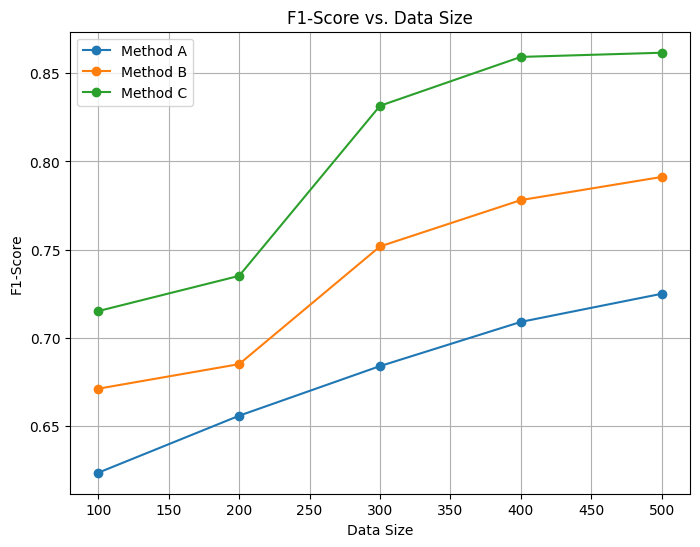

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

# 模拟数据集
data_sizes = [100, 200, 300, 400, 500]  # 数据量逐步增加
f1_scores_A = [0.62361, 0.65591, 0.68405, 0.70910, 0.72505]  # A方法的F1-Score
f1_scores_B = [0.67123, 0.68515, 0.75186, 0.77813, 0.79125]  # B方法的F1-Score
f1_scores_C = [0.71521, 0.73518, 0.83157, 0.85927, 0.86164]  # C方法的F1-Score

# 绘制折线图
plt.figure(figsize=(8, 6))
plt.plot(data_sizes, f1_scores_A, marker='o', label='Method A')
plt.plot(data_sizes, f1_scores_B, marker='o', label='Method B')
plt.plot(data_sizes, f1_scores_C, marker='o', label='Method C')
plt.xlabel('Data Size')
plt.ylabel('F1-Score')
plt.title('F1-Score vs. Data Size')
plt.legend()
plt.grid(True)
plt.show()


# 训练最佳模型参数

In [237]:
from sklearn.model_selection import GridSearchCV

# 从文件读取数据
data = []
labels = []
with open("/root/commandDetect/kg/command_data.test2", "r") as file:
    for line in file:
        parts = line.strip().split('\"')
        if len(parts) >= 4:
            uid, timestamp, ppcomm, pcomm, cmdline = parts[1], parts[3], parts[5], parts[9], parts[11]
            data.append([uid, timestamp, ppcomm, pcomm, cmdline])
        labels.append(int(line.strip()[-1]))
data_tmp = data
data = np.array(data)

# 提取时间并编码
timestamps = [np.datetime64(item[0]) for item in data]
le_timestamp = LabelEncoder()
data[:, 1] = le_timestamp.fit_transform(timestamps)

# 将进程名编码为整数
le_process = LabelEncoder()
data[:, 0] = le_process.fit_transform(data[:, 0])
data[:, 2] = le_process.fit_transform(data[:, 2])
data[:, 3] = le_process.fit_transform(data[:, 3])
data[:, 4] = le_process.fit_transform(data[:, 4])

# 准备参数网格进行Grid Search
param_grid = {
    'n_estimators': [100, 200, 300],
    'contamination': [0.01, 0.05, 0.1],
    'max_samples': ['auto', 100, 200]
}

# 创建Isolation Forest模型
model = IsolationForest()

# 使用Grid Search进行参数搜索
grid_search = GridSearchCV(model, param_grid, cv=3, scoring='f1', n_jobs=-1)
grid_search.fit(data, labels)

# 输出最佳参数
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数创建Isolation Forest模型
best_model = IsolationForest(n_estimators=best_params['n_estimators'],
                             contamination=best_params['contamination'],
                             max_samples=best_params['max_samples'],
                             random_state=42)
best_model.fit(data)

# 进行异常检测
predictions = best_model.predict(data)
"""
for i, pred in enumerate(predictions):
    if pred == -1:
        print(f"进程链 {i + 1} 可能是入侵")
        print(data_tmp[i])
    else:
        print(f"进程链 {i + 1} 正常")

predictions = [1 if pred == -1 else 0 for pred in predictions]
"""
# 计算指标
accuracy = accuracy_score(labels, predictions)
recall = recall_score(labels, predictions, average='macro')
f1 = f1_score(labels, predictions, average='macro')

print("Accuracy:", accuracy)
print("Recall:", recall)
print("F1 Score:", f1)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 810, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/_param_validation.py", line 214, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1239, in f1_score
   

Best Parameters: {'contamination': 0.01, 'max_samples': 'auto', 'n_estimators': 100}
Accuracy: 0.09328358208955224
Recall: 0.32051282051282054
F1 Score: 0.05707762557077625


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# LOF

In [61]:
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def run_lof_original():
    data = []
    labels = []

    with open("/root/commandDetect/kg/command_data.test2", "r") as file:
        for line in file:
            parts = line.strip().split('\"')
            if len(parts) >= 4:
                uid, timestamp, pcomm, ppcomm, ppid, cmdline = parts[1], parts[3], parts[5], parts[9], parts[11], parts[15]
                data.append([uid, timestamp, ppcomm, pcomm, cmdline])
            labels.append(int(line.strip()[-1]))

    data_tmp = data
    data = np.array(data)

    # Convert timestamps to datetime objects and encode
    timestamps = [np.datetime64(item[1]) for item in data]
    le_timestamp = LabelEncoder()
    data[:, 1] = le_timestamp.fit_transform(timestamps)

    # Encode process names as integers
    le_process = LabelEncoder()
    data[:, 0] = le_process.fit_transform(data[:, 1])
    data[:, 2] = le_process.fit_transform(data[:, 2])
    data[:, 3] = le_process.fit_transform(data[:, 3])
    
    # Convert cmdline to numeric values
    le_cmdline = LabelEncoder()
    data[:, 4] = le_cmdline.fit_transform(data[:, 4])

    data = np.array(data, dtype=np.float64)
    
    # Create and fit the LOF model
    clf = LocalOutlierFactor(contamination=0.01)
    predictions = clf.fit_predict(data)

    for i, pred in enumerate(predictions):
        if pred == -1:
            print(f"进程链 {i+1} 可能是入侵")
            print(data_tmp[i])
        else:
            print(f"进程链 {i+1} 正常")

    # 计算指标
    precision = accuracy_score(labels, predictions)
    accuracy = accuracy_score(labels, predictions)
    recall = recall_score(labels, predictions, average='macro')
    f1 = f1_score(labels, predictions, average='macro')
    
    print("Accuracy:", accuracy)
    print("Precision", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)

def run_lof_graph():
    from py2neo import Graph
    graph = Graph("bolt://localhost:7687", user="neo4j", password="123456")
    query1 = """
        CALL gds.louvain.stream('myGraph')
        YIELD nodeId, communityId, intermediateCommunityIds
        RETURN DISTINCT communityId
        ORDER BY communityId ASC
    """  
    result1 = graph.run(query1).data()
    
    community_ids = [record['communityId'] for record in result1]

    community_results = []

    all_labels = []
    all_predictions = []
    
    for community_id in community_ids:
        query2 = f"""
            CALL gds.louvain.stream('myGraph')
            YIELD nodeId, communityId, intermediateCommunityIds
            WHERE communityId = {community_id}
            MATCH (n)-[r]->(m)
            WHERE id(n) = nodeId
            RETURN n, r, m
            ORDER BY communityId ASC 
        """
        result2 = graph.run(query2).data()
        community_results.append(result2)

    for i, community_id in enumerate(community_ids):
        data = []
        labels = []
        print("****"*10)
        print(f"Community {community_id}:")
        
        for record in community_results[i]:        
            ppnode = record['n']
            relationship = record['r']
            pnode = record['m']
            uid, timestamp, pcomm, ppcomm, ppid, cmdline, label = relationship['uid'],  relationship['time'], pnode['name'], ppnode['name'], ppnode['pid'], relationship['cmdline'], relationship['label']
            data.append([uid, ppcomm, pcomm, cmdline])
            labels.append(label)
            
       # print(data)
        data_tmp = data
        data = np.array(data)

        # 将进程名编码为整数
        le_process = LabelEncoder()
        data[:, 0] = le_process.fit_transform(data[:, 0])
        data[:, 1] = le_process.fit_transform(data[:, 1])
        data[:, 2] = le_process.fit_transform(data[:, 2])
        data[:, 3] = le_process.fit_transform(data[:, 3])

        data = np.array(data, dtype=np.float64)
        
        clf = LocalOutlierFactor(contamination=0.01)
        predictions = clf.fit_predict(data)
        
        for i, pred in enumerate(predictions):
            if pred == -1:
                print(f"进程链 {i+1} 可能是入侵")
                print(data_tmp[i])
            else:
                print(f"进程链 {i+1} 正常")

        predictions = [1 if pred == -1 else 0 for pred in predictions]
        all_labels.append(labels)
        all_predictions.append(predictions)


    all_labels = [label for sublist in all_labels for label in sublist]
    all_predictions = [prediction for sublist in all_predictions for prediction in sublist]
    
    precision = accuracy_score(all_labels, all_predictions)
    accuracy = accuracy_score(all_labels, all_predictions)
    recall = recall_score(all_labels, all_predictions, average='macro')
    f1 = f1_score(all_labels, all_predictions, average='macro')

    print("Accuracy:", accuracy)
    print("Precision", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)

def run_lof_graph_plus():
    from py2neo import Graph
    graph = Graph("bolt://localhost:7687", user="neo4j", password="123456")
    query1 = """
        CALL gds.louvain.stream('myGraph')
        YIELD nodeId, communityId, intermediateCommunityIds
        RETURN DISTINCT communityId
        ORDER BY communityId ASC
    """  
    result1 = graph.run(query1).data()
    
    community_ids = [record['communityId'] for record in result1]

    community_results = []
    
    all_labels = []
    all_predictions = []
    
    for community_id in community_ids:
        query2 = f"""
        CALL gds.louvain.stream('myGraph')
        YIELD nodeId, communityId, intermediateCommunityIds
        WHERE communityId = {community_id}
        MATCH (n)-[r]->(m)
        WHERE id(n) = nodeId
        RETURN n, r, m
        ORDER BY communityId ASC
        """
        result2 = graph.run(query2).data()
        community_results.append(result2)

    for i, community_id in enumerate(community_ids):
        data = []
        labels = []
        print("****"*10)
        print(f"Community {community_id}:")
        
        for record in community_results[i]:
            
            ppnode = record['n']
            relationship = record['r']
            pnode = record['m']
            uid, timestamp, pcomm, ppcomm, ppid, option, label = relationship['uid'],  relationship['time'], pnode['name'], ppnode['name'], ppnode['pid'], relationship['option'], relationship['label']
            data.append([uid, ppcomm, pcomm, option])
            labels.append(label)
            
        #print(data)
        data_tmp = data
        data = np.array(data)
            
        # 将进程名编码为整数
        le_process = LabelEncoder()
        data[:, 0] = le_process.fit_transform(data[:, 0])
        data[:, 1] = le_process.fit_transform(data[:, 1])
        data[:, 2] = le_process.fit_transform(data[:, 2])
        data[:, 3] = le_process.fit_transform(data[:, 3])
        
        data = np.array(data, dtype=np.float64)
        n_neighbors = min(data.shape[0], 2)
        print(data.shape[0])
        clf = LocalOutlierFactor(contamination=0.01, n_neighbors=n_neighbors)
        predictions = clf.fit_predict(data)
     
        for i, pred in enumerate(predictions):
            if pred == -1:
                print(f"进程链 {i+1} 可能是入侵")
                print(data_tmp[i])
            else:
                print(f"进程链 {i+1} 正常")
                
        predictions = [1 if pred == -1 else 0 for pred in predictions]
        all_labels.append(labels)
        all_predictions.append(predictions)
        
    all_labels = [label for sublist in all_labels for label in sublist]
    all_predictions = [prediction for sublist in all_predictions for prediction in sublist]

    precision = accuracy_score(all_labels, all_predictions)
    accuracy = accuracy_score(all_labels, all_predictions)
    recall = recall_score(all_labels, all_predictions, average='macro')
    f1 = f1_score(all_labels, all_predictions, average='macro')

    
    print("Accuracy:", accuracy)
    print("Precision", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)

In [73]:
run_lof_original()

进程链 1 正常
进程链 2 正常
进程链 3 可能是入侵
['0', '2023-10-29 15:32:31', 'bash', 'whoami', 'whoami']
进程链 4 正常
进程链 5 正常
进程链 6 正常
进程链 7 正常
进程链 8 正常
进程链 9 正常
进程链 10 正常
进程链 11 正常
进程链 12 正常
进程链 13 正常
进程链 14 正常
进程链 15 正常
进程链 16 正常
进程链 17 正常
进程链 18 正常
进程链 19 正常
进程链 20 正常
进程链 21 正常
进程链 22 正常
进程链 23 可能是入侵
['0', '2023-10-29 15:35:13', 'bash', 'docker', 'docker ps']
进程链 24 正常
进程链 25 正常
进程链 26 正常
进程链 27 正常
进程链 28 正常
进程链 29 正常
进程链 30 正常
进程链 31 正常
进程链 32 正常
进程链 33 正常
进程链 34 正常
进程链 35 正常
进程链 36 正常
进程链 37 正常
进程链 38 正常
进程链 39 正常
进程链 40 正常
进程链 41 正常
进程链 42 正常
进程链 43 正常
进程链 44 正常
进程链 45 正常
进程链 46 正常
进程链 47 正常
进程链 48 正常
进程链 49 正常
进程链 50 正常
进程链 51 正常
进程链 52 正常
进程链 53 正常
进程链 54 正常
进程链 55 正常
进程链 56 正常
进程链 57 正常
进程链 58 正常
进程链 59 正常
进程链 60 正常
进程链 61 正常
进程链 62 正常
进程链 63 正常
进程链 64 正常
进程链 65 正常
进程链 66 正常
进程链 67 正常
进程链 68 正常
进程链 69 正常
进程链 70 可能是入侵
['0', '2023-10-29 15:32:31', 'bash', 'whoami', 'whoami']
进程链 71 正常
进程链 72 正常
进程链 73 正常
进程链 74 正常
进程链 75 正常
进程链 76 正常
进程链 77 正常
进程链 78 正常
进程链 79 正常
进程链 80 正常
进程链 81 正常
进程链 82 正常
进程链 83

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# KNN

In [56]:
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, recall_score, f1_score

def run_knn_original():
    data = []
    labels = []

    with open("/root/commandDetect/kg/command_data.test2", "r") as file:
        for line in file:
            parts = line.strip().split('\"')
            if len(parts) >= 4:
                uid, timestamp, pcomm, ppcomm, ppid, cmdline = parts[1], parts[3], parts[5], parts[9], parts[11], parts[15]
                data.append([uid, timestamp, ppcomm, pcomm, cmdline])
            labels.append(int(line.strip()[-1]))

    data_tmp = data
    data = np.array(data)

    # Convert timestamps to datetime objects and encode
    timestamps = [np.datetime64(item[1]) for item in data]
    le_timestamp = LabelEncoder()
    data[:, 1] = le_timestamp.fit_transform(timestamps)

    # Encode process names as integers
    le_process = LabelEncoder()
    data[:, 0] = le_process.fit_transform(data[:, 1])
    data[:, 2] = le_process.fit_transform(data[:, 2])
    data[:, 3] = le_process.fit_transform(data[:, 3])
    
    # Convert cmdline to numeric values
    le_cmdline = LabelEncoder()
    data[:, 4] = le_cmdline.fit_transform(data[:, 4])

    data = np.array(data, dtype=np.float64)
    
    n_neighbors = min(data.shape[0], 5)  # You can adjust this parameter based on your requirements
    clf = KNeighborsClassifier(n_neighbors=n_neighbors)

    # Fit the model
    clf.fit(data, labels)

    # Make predictions
    predictions = clf.predict(data)

    for i, pred in enumerate(predictions):
        if pred == -1:
            print(f"进程链 {i+1} 可能是入侵")
            print(data_tmp[i])
        else:
            print(f"进程链 {i+1} 正常")

    # 计算指标
    precision = accuracy_score(labels, predictions)
    accuracy = accuracy_score(labels, predictions)
    recall = recall_score(labels, predictions, average='macro')
    f1 = f1_score(labels, predictions, average='macro')
    
    print("Accuracy:", accuracy)
    print("Precision", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)

def run_knn_graph_plus():
    from py2neo import Graph
    graph = Graph("bolt://localhost:7687", user="neo4j", password="123456")
    query1 = """
        CALL gds.louvain.stream('myGraph')
        YIELD nodeId, communityId, intermediateCommunityIds
        RETURN DISTINCT communityId
        ORDER BY communityId ASC
    """  
    result1 = graph.run(query1).data()
    
    community_ids = [record['communityId'] for record in result1]

    community_results = []
    
    all_labels = []
    all_predictions = []
    
    for community_id in community_ids:
        query2 = f"""
        CALL gds.louvain.stream('myGraph')
        YIELD nodeId, communityId, intermediateCommunityIds
        WHERE communityId = {community_id}
        MATCH (n)-[r]->(m)
        WHERE id(n) = nodeId
        RETURN n, r, m
        ORDER BY communityId ASC
        """
        result2 = graph.run(query2).data()
        community_results.append(result2)

    for i, community_id in enumerate(community_ids):
        data = []
        labels = []
        print("****"*10)
        print(f"Community {community_id}:")
        
        for record in community_results[i]:
            
            ppnode = record['n']
            relationship = record['r']
            pnode = record['m']
            uid, timestamp, pcomm, ppcomm, ppid, option, label = relationship['uid'],  relationship['time'], pnode['name'], ppnode['name'], ppnode['pid'], relationship['option'], relationship['label']
            data.append([uid, ppcomm, pcomm, option])
            labels.append(label)
            
        #print(data)
        data_tmp = data
        data = np.array(data)

        # 将进程名编码为整数
        le_process = LabelEncoder()
        data[:, 0] = le_process.fit_transform(data[:, 0])
        data[:, 1] = le_process.fit_transform(data[:, 1])
        data[:, 2] = le_process.fit_transform(data[:, 2])
        data[:, 3] = le_process.fit_transform(data[:, 3])
        
        data = np.array(data, dtype=np.float64)
    
        n_neighbors = min(data.shape[0], 5)  # You can adjust this parameter based on your requirements
        clf = KNeighborsClassifier(n_neighbors=n_neighbors)
    
        # Fit the model
        clf.fit(data, labels)
        predictions = clf.predict(data)
     
        for i, pred in enumerate(predictions):
            if pred == -1:
                print(f"进程链 {i+1} 可能是入侵")
                print(data_tmp[i])
            else:
                print(f"进程链 {i+1} 正常")
                
        predictions = [1 if pred == -1 else 0 for pred in predictions]
        all_labels.append(labels)
        all_predictions.append(predictions)
        
    all_labels = [label for sublist in all_labels for label in sublist]
    all_predictions = [prediction for sublist in all_predictions for prediction in sublist]

    precision = accuracy_score(all_labels, all_predictions)
    accuracy = accuracy_score(all_labels, all_predictions)
    recall = recall_score(all_labels, all_predictions, average='macro')
    f1 = f1_score(all_labels, all_predictions, average='macro')

    
    print("Accuracy:", accuracy)
    print("Precision", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)

In [57]:
run_knn_graph_plus()

****************************************
Community 5:
进程链 1 正常
进程链 2 正常
进程链 3 正常
进程链 4 正常
进程链 5 正常
进程链 6 正常
进程链 7 正常
进程链 8 正常
进程链 9 正常
进程链 10 正常
进程链 11 正常
进程链 12 正常
进程链 13 正常
进程链 14 正常
进程链 15 正常
进程链 16 正常
进程链 17 正常
进程链 18 正常
进程链 19 正常
进程链 20 正常
进程链 21 正常
进程链 22 正常
进程链 23 正常
进程链 24 正常
进程链 25 正常
进程链 26 正常
进程链 27 正常
进程链 28 正常
进程链 29 正常
进程链 30 正常
进程链 31 正常
进程链 32 正常
进程链 33 正常
进程链 34 正常
进程链 35 正常
进程链 36 正常
进程链 37 正常
进程链 38 正常
进程链 39 正常
进程链 40 正常
进程链 41 正常
进程链 42 正常
进程链 43 正常
进程链 44 正常
进程链 45 正常
进程链 46 正常
进程链 47 正常
进程链 48 正常
进程链 49 正常
进程链 50 正常
进程链 51 正常
进程链 52 正常
进程链 53 正常
进程链 54 正常
进程链 55 正常
进程链 56 正常
进程链 57 正常
进程链 58 正常
进程链 59 正常
进程链 60 正常
进程链 61 正常
进程链 62 正常
进程链 63 正常
进程链 64 正常
进程链 65 正常
进程链 66 正常
进程链 67 正常
进程链 68 正常
进程链 69 正常
进程链 70 正常
进程链 71 正常
****************************************
Community 11:
进程链 1 正常
进程链 2 正常
进程链 3 正常
进程链 4 正常
进程链 5 正常
进程链 6 正常
进程链 7 正常
进程链 8 正常
进程链 9 正常
进程链 10 正常
进程链 11 正常
进程链 12 正常
进程链 13 正常
进程链 14 正常
进程链 15 正常
进程链 16 正常
进程链 17 正常
进程链 18 正常
进程链 19 正常
进程链 20 正常

# SVM

In [66]:
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import OneClassSVM
from sklearn.metrics import accuracy_score, recall_score, f1_score

def run_svm_original():
    data = []
    labels = []

    with open("/root/commandDetect/kg/command_data.test2", "r") as file:
        for line in file:
            parts = line.strip().split('\"')
            if len(parts) >= 4:
                uid, timestamp, pcomm, ppcomm, ppid, cmdline = parts[1], parts[3], parts[5], parts[9], parts[11], parts[15]
                data.append([uid, timestamp, ppcomm, pcomm, cmdline])
            labels.append(int(line.strip()[-1]))

    data_tmp = data
    data = np.array(data)

    # Convert timestamps to datetime objects and encode
    timestamps = [np.datetime64(item[1]) for item in data]
    le_timestamp = LabelEncoder()
    data[:, 1] = le_timestamp.fit_transform(timestamps)

    # Encode process names as integers
    le_process = LabelEncoder()
    data[:, 0] = le_process.fit_transform(data[:, 1])
    data[:, 2] = le_process.fit_transform(data[:, 2])
    data[:, 3] = le_process.fit_transform(data[:, 3])
    data[:, 4] = le_process.fit_transform(data[:, 4])
    data = np.array(data, dtype=np.float64)
    # Create and fit the One-Class SVM model
    clf = OneClassSVM(nu=0.01)  # Adjust nu based on your requirements
    clf.fit(data)

    # Make predictions
    predictions = clf.predict(data)

    for i, pred in enumerate(predictions):
        if pred == -1:
            print(f"进程链 {i+1} 可能是入侵")
            print(data_tmp[i])
        else:
            print(f"进程链 {i+1} 正常")

    predictions = [1 if pred == -1 else 0 for pred in predictions]

    # Evaluate the model
    precision = accuracy_score(labels, predictions)
    accuracy = accuracy_score(labels, predictions)
    recall = recall_score(labels, predictions, average='macro')
    f1 = f1_score(labels, predictions, average='macro')

    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)

def run_svm_graph_plus():
    from py2neo import Graph
    graph = Graph("bolt://localhost:7687", user="neo4j", password="123456")
    query1 = """
        CALL gds.louvain.stream('myGraph')
        YIELD nodeId, communityId, intermediateCommunityIds
        RETURN DISTINCT communityId
        ORDER BY communityId ASC
    """  
    result1 = graph.run(query1).data()
    
    community_ids = [record['communityId'] for record in result1]

    community_results = []
    
    all_labels = []
    all_predictions = []
    
    for community_id in community_ids:
        query2 = f"""
        CALL gds.louvain.stream('myGraph')
        YIELD nodeId, communityId, intermediateCommunityIds
        WHERE communityId = {community_id}
        MATCH (n)-[r]->(m)
        WHERE id(n) = nodeId
        RETURN n, r, m
        ORDER BY communityId ASC
        """
        result2 = graph.run(query2).data()
        community_results.append(result2)

    for i, community_id in enumerate(community_ids):
        data = []
        labels = []
        print("****"*10)
        print(f"Community {community_id}:")
        
        for record in community_results[i]:
            
            ppnode = record['n']
            relationship = record['r']
            pnode = record['m']
            uid, timestamp, pcomm, ppcomm, ppid, option, label = relationship['uid'],  relationship['time'], pnode['name'], ppnode['name'], ppnode['pid'], relationship['option'], relationship['label']
            data.append([uid, ppcomm, pcomm, option])
            labels.append(label)
            
        #print(data)
        data_tmp = data
        data = np.array(data)

        # 将进程名编码为整数
        le_process = LabelEncoder()
        data[:, 0] = le_process.fit_transform(data[:, 0])
        data[:, 1] = le_process.fit_transform(data[:, 1])
        data[:, 2] = le_process.fit_transform(data[:, 2])
        data[:, 3] = le_process.fit_transform(data[:, 3])
        
        data = np.array(data, dtype=np.float64)
    
            # Create and fit the One-Class SVM model
        clf = OneClassSVM(nu=0.01)  # Adjust nu based on your requirements
        clf.fit(data)
        predictions = clf.predict(data)
     
        for i, pred in enumerate(predictions):
            if pred == -1:
                print(f"进程链 {i+1} 可能是入侵")
                print(data_tmp[i])
            else:
                print(f"进程链 {i+1} 正常")
                
        predictions = [1 if pred == -1 else 0 for pred in predictions]
        all_labels.append(labels)
        all_predictions.append(predictions)
        
    all_labels = [label for sublist in all_labels for label in sublist]
    all_predictions = [prediction for sublist in all_predictions for prediction in sublist]

    precision = accuracy_score(all_labels, all_predictions)
    accuracy = accuracy_score(all_labels, all_predictions)
    recall = recall_score(all_labels, all_predictions, average='macro')
    f1 = f1_score(all_labels, all_predictions, average='macro')

    
    print("Accuracy:", accuracy)
    print("Precision", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)

In [67]:
run_one_class_svm()

进程链 1 可能是入侵
['0', '2023-10-29 15:32:29', 'bash', 'ifconfig', 'ifconfig']
进程链 2 可能是入侵
['0', '2023-10-29 15:32:30', 'bash', 'whoami', 'whoami']
进程链 3 正常
进程链 4 正常
进程链 5 正常
进程链 6 正常
进程链 7 正常
进程链 8 正常
进程链 9 正常
进程链 10 正常
进程链 11 正常
进程链 12 可能是入侵
['0', '2023-10-29 15:33:03', 'runc', 'bash', 'bash']
进程链 13 正常
进程链 14 正常
进程链 15 正常
进程链 16 正常
进程链 17 正常
进程链 18 正常
进程链 19 正常
进程链 20 正常
进程链 21 正常
进程链 22 正常
进程链 23 正常
进程链 24 正常
进程链 25 正常
进程链 26 正常
进程链 27 正常
进程链 28 正常
进程链 29 正常
进程链 30 正常
进程链 31 正常
进程链 32 正常
进程链 33 正常
进程链 34 正常
进程链 35 正常
进程链 36 正常
进程链 37 正常
进程链 38 正常
进程链 39 正常
进程链 40 正常
进程链 41 正常
进程链 42 正常
进程链 43 正常
进程链 44 正常
进程链 45 正常
进程链 46 正常
进程链 47 正常
进程链 48 正常
进程链 49 正常
进程链 50 正常
进程链 51 正常
进程链 52 正常
进程链 53 正常
进程链 54 正常
进程链 55 正常
进程链 56 正常
进程链 57 正常
进程链 58 正常
进程链 59 正常
进程链 60 正常
进程链 61 正常
进程链 62 正常
进程链 63 正常
进程链 64 正常
进程链 65 正常
进程链 66 正常
进程链 67 正常
进程链 68 可能是入侵
['0', '2023-10-29 15:32:29', 'bash', 'ifconfig', 'ifconfig']
进程链 69 可能是入侵
['0', '2023-10-29 15:32:30', 'bash', 'whoami', 'whoami']
进程链 70 正常
进程链 7

In [68]:
run_svm_graph_plus()

****************************************
Community 5:
进程链 1 正常
进程链 2 正常
进程链 3 正常
进程链 4 正常
进程链 5 正常
进程链 6 正常
进程链 7 正常
进程链 8 正常
进程链 9 正常
进程链 10 正常
进程链 11 正常
进程链 12 正常
进程链 13 正常
进程链 14 正常
进程链 15 正常
进程链 16 正常
进程链 17 正常
进程链 18 正常
进程链 19 正常
进程链 20 正常
进程链 21 正常
进程链 22 正常
进程链 23 正常
进程链 24 正常
进程链 25 正常
进程链 26 正常
进程链 27 正常
进程链 28 正常
进程链 29 正常
进程链 30 正常
进程链 31 正常
进程链 32 正常
进程链 33 正常
进程链 34 正常
进程链 35 正常
进程链 36 正常
进程链 37 正常
进程链 38 正常
进程链 39 正常
进程链 40 正常
进程链 41 正常
进程链 42 正常
进程链 43 正常
进程链 44 正常
进程链 45 正常
进程链 46 正常
进程链 47 正常
进程链 48 正常
进程链 49 正常
进程链 50 正常
进程链 51 正常
进程链 52 正常
进程链 53 正常
进程链 54 正常
进程链 55 正常
进程链 56 正常
进程链 57 正常
进程链 58 正常
进程链 59 正常
进程链 60 正常
进程链 61 正常
进程链 62 正常
进程链 63 正常
进程链 64 正常
进程链 65 正常
进程链 66 正常
进程链 67 正常
进程链 68 正常
进程链 69 正常
进程链 70 正常
进程链 71 正常
****************************************
Community 11:
进程链 1 可能是入侵
['1000', 'gitaly', 'ps', '进程操作']
进程链 2 可能是入侵
['1000', 'gitaly', 'ps', '进程操作']
进程链 3 可能是入侵
['1000', 'gitaly', 'ps', '进程操作']
进程链 4 可能是入侵
['1000', 'gitaly', 'ps', '进程操作']
进程链 5 可能是入